In [1]:
from lstm_clv.data_types import UserAttributes, UserEvents
from lstm_clv.libs.path_management import ExperimentPaths
from lstm_clv.api_utils import plot_distribution, describe_values
import pandas as pd
import numpy as np

def pretty_print_journey(v: np.ndarray) -> np.ndarray:
    """Pretty print"""
    return np.transpose(v.astype(int))

def flatten_events(events: UserEvents) -> np.ndarray:
    """Return a 2d array (products x week-user combinations) from UserEvents"""
    event_len = events.histories.shape[0] * events.histories.shape[1]
    return events.histories.reshape((event_len, events.histories.shape[2]))

CDNOW = ExperimentPaths("cdnow")
FINTECH_AGGR = ExperimentPaths("fintech_aggregated")
FINTECH_PROD = ExperimentPaths("fintech_product_level")


In [2]:
events = UserEvents.load(FINTECH_PROD.transactions_matrix)
attrs = UserAttributes.load(FINTECH_PROD.user_attrs)

# reduce all customers to a single dimension
events_long = flatten_events(events)

# anonymize column names
event_names = [
    "application_opened", "product A", "product B", "product C", 
    "user_info_shared", "product D", "product E"
]
attr_names = [
    "age", "attr 1", "attr 2", "attr 3", "channel 1", "channel 2", "channel 3", 
    "employment 1", "employment 2", "employment 3", 
    "responsiveness 1", "responsiveness 2", "responsiveness 3"
]

In [3]:
# distribution of event (activity) data

print(f"Nonzero events (total): {(events_long > 0).mean():.4f} %")
describe_values(events_long, axis=0, names=event_names).round(2)

Nonzero events (total): 0.1278 %


,min,mean,max,std,skew,kurtosis,nonzero
application_opened,0.0,8.71,2738.00,29.33,11.07,267.79,0.38
product A,0.0,23.06,394808.67,1140.80,189.26,49802.16,0.08
product B,0.0,21.23,19129.53,162.56,20.67,787.68,0.09
product C,0.0,64.72,802863.58,1461.90,217.17,87203.22,0.06
user_info_shared,0.0,0.05,38.00,0.38,16.23,536.43,0.03
product D,0.0,76.94,1804996.75,3686.84,355.13,152334.29,0.14
product E,0.0,77.18,26405.89,611.01,15.17,301.61,0.10


In [4]:
# distribution of demographic data

describe_values(attrs.df.drop("user_id", axis=1).values, axis=0, names=attr_names).round(2)

,min,mean,max,std,skew,kurtosis,nonzero
age,19.0,41.10,101.0,12.61,0.44,-0.35,1.00
attr 1,0.0,0.86,1.0,0.35,-2.06,2.24,0.86
attr 2,0.0,0.75,1.0,0.43,-1.18,-0.62,0.75
attr 3,0.0,0.32,1.0,0.47,0.79,-1.38,0.32
channel 1,0.0,0.20,1.0,0.40,1.48,0.18,0.20
channel 2,0.0,0.09,1.0,0.29,2.85,6.10,0.09
channel 3,0.0,0.06,1.0,0.23,3.90,13.23,0.06
employment 1,0.0,0.22,1.0,0.41,1.37,-0.13,0.22
employment 2,0.0,0.58,1.0,0.49,-0.34,-1.88,0.58
employment 3,0.0,0.09,1.0,0.28,2.93,6.56,0.09


In [5]:
# example of event (activity) data for a customer (12 first weeks)

pretty_print_journey(events.get_user_history(events.users[0])[0:12])

array([[ 0,  0,  4, 12,  9,  3,  0,  0,  0,  5,  9, 12],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14, 34],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0, 37,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 12,  0,  0]])

In [6]:
# distribution of fintech data aggregated

events = UserEvents.load(FINTECH_AGGR.transactions_matrix)
events_long = flatten_events(events)

describe_values(events_long, axis=0, names=["revenue"]).round(2)

,min,mean,max,std,skew,kurtosis,nonzero
revenue,0.0,2.64,18049.97,44.28,225.96,75984.71,0.3


In [7]:
# distribution of CDNow data

events = UserEvents.load(CDNOW.transactions_matrix)
events_long = flatten_events(events)

describe_values(events_long, axis=0, names=["purchase"]).round(2)

,min,mean,max,std,skew,kurtosis,nonzero
purchase,0.0,6.0,3445.11,24.73,25.96,2539.0,0.13


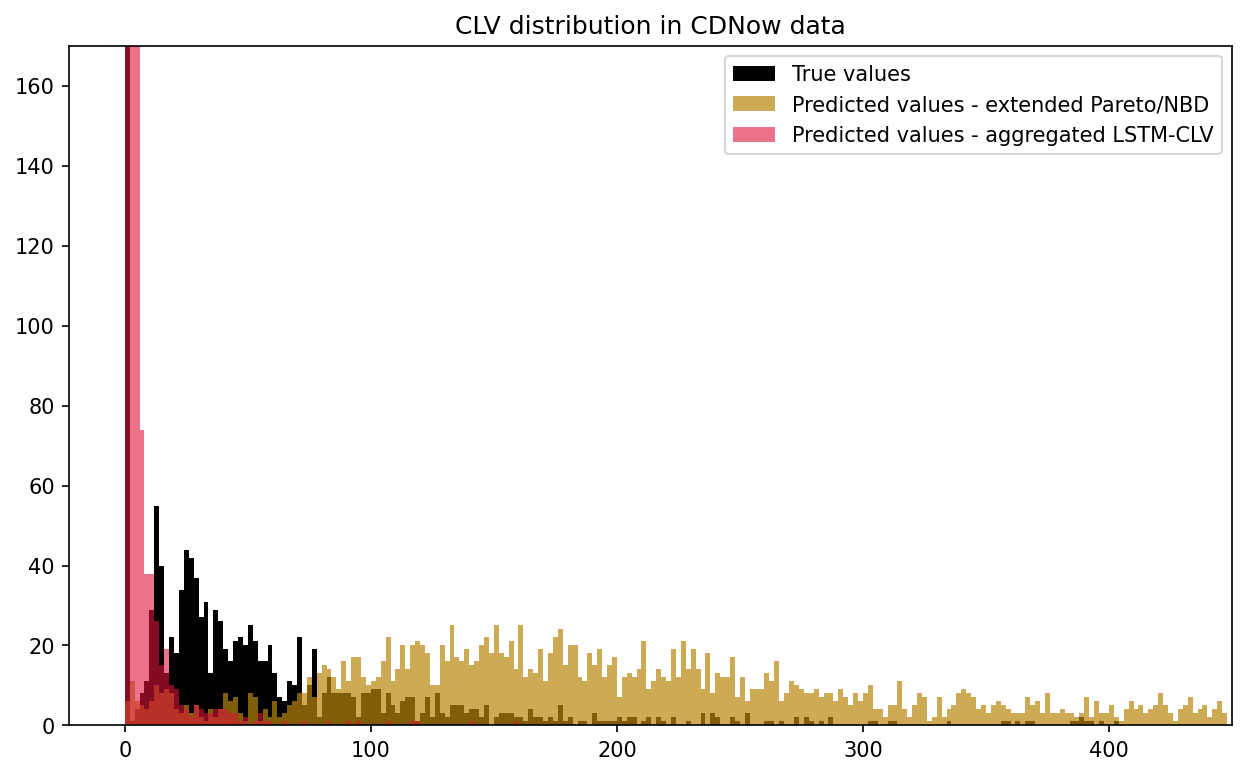

In [8]:
cdnow_benchmark = pd.read_csv(CDNOW.benchmark_preds)
cdnow_lstmclv = pd.read_csv(CDNOW.lstm_preds)

plot_distribution(
    true_values=cdnow_benchmark["clv_true"], 
    pnbd_values=cdnow_benchmark["clv_pred"],
    lstm_values_aggr=cdnow_lstmclv["pred_clv"],
    lstm_values_prod=None,
    bin_width=2, 
    right_limit=450, 
    upper_limit=170,
    title="CLV distribution in CDNow data",
)

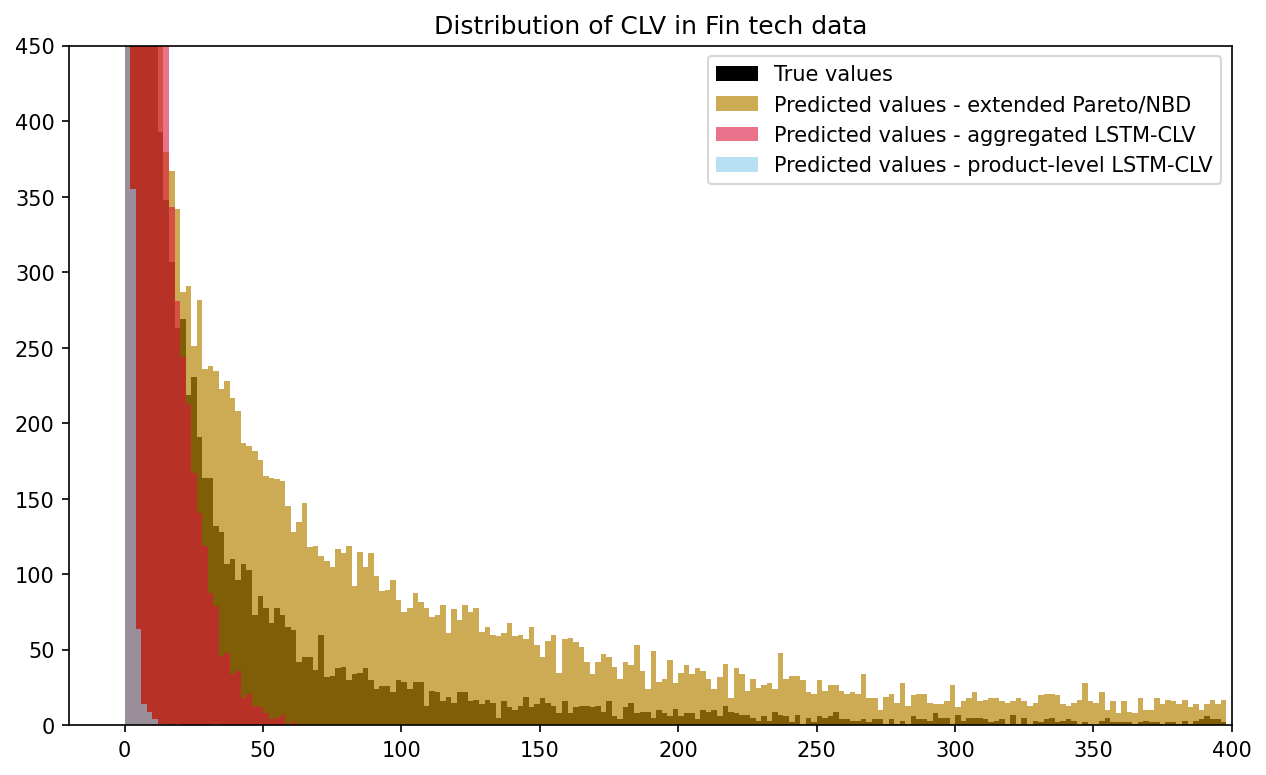

In [9]:
fintech_benchmark = pd.read_csv(FINTECH_AGGR.benchmark_preds)
fintech_lstmclv_aggr = pd.read_csv(FINTECH_AGGR.lstm_preds)
fintech_lstmclv_prod = pd.read_csv(FINTECH_PROD.lstm_preds)

plot_distribution(
    true_values=fintech_benchmark["clv_true"], 
    pnbd_values=fintech_benchmark["clv_pred"],
    lstm_values_aggr=fintech_lstmclv_aggr["pred_clv"],
    lstm_values_prod=fintech_lstmclv_prod["pred_clv"],
    bin_width=2, 
    right_limit=400, 
    upper_limit=450,
    title="Distribution of CLV in Fintech data",
)